# ViT Implementation: step 1, selecting the best model


## Imports

In [ ]:
from google.colab import drive

import zipfile
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import cv2

from transformers import ViTImageProcessor, ViTForImageClassification
import requests
import random

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from tqdm import tqdm

import math
import json
import torchvision
import csv

## Data importation

Allow this notebook access to google drive:

In [ ]:
# Use drive.mount with force_remount=True
drive.mount('/content/drive')

Mounted at /content/drive


Extract the data from the zip file in the drive, to the Colab working directory (~40s runtime) :

In [ ]:
# Path to your ZIP file in Google Drive
zip_path = '/content/drive/MyDrive/ML Project 2 :)/data (2).zip'

# Extract to a working directory
extract_path = '/content/dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

## Finding the normalisation parameters

In [ ]:
# Define transforms for resizing

transform = transforms.Compose([
    transforms.ToTensor()  # Converts image to Tensor with values [0, 1]
])

# Load training and validation dataset
train_dataset = datasets.ImageFolder(os.path.join(extract_path, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(extract_path, 'validation'), transform=transform)

In [ ]:
# DataLoader pour le batching

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#### Normalisation

In [ ]:
# Initialize accumulators for each channel
channel_sum = torch.zeros(3)  # R, G, B
channel_squared_sum = torch.zeros(3)
total_pixels = 0

# Iterate through the dataset
for images, _ in train_loader:
    # images shape: [batch_size, 3, height, width]
    batch_pixels = images.size(0) * images.size(2) * images.size(3)  # Total pixels per batch
    total_pixels += batch_pixels

    # Sum and squared sum for each channel
    channel_sum += images.sum(dim=[0, 2, 3])  # Sum across batch and spatial dimensions
    channel_squared_sum += (images ** 2).sum(dim=[0, 2, 3])  # Squared sum across batch and spatial dimensions

# Compute mean and standard deviation for each channel
mean = channel_sum / total_pixels
std = torch.sqrt(channel_squared_sum / total_pixels - mean ** 2)

print(f"Per-Channel Mean: {mean}")
print(f"Per-Channel Std: {std}")

mean_list = mean.tolist()
std_list = std.tolist()

import csv


# Chemin du fichier CSV
stats_file = 'dataset_stats.csv'

# Sauvegarder les valeurs dans un fichier CSV
with open(stats_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Channel', 'Mean', 'Std'])  # En-têtes
    writer.writerow(['R', mean_list[0], std_list[0]])      # Canal Rouge
    writer.writerow(['G', mean_list[1], std_list[1]])      # Canal Vert
    writer.writerow(['B', mean_list[2], std_list[2]])      # Canal Bleu

print(f"Les statistiques ont été enregistrées dans {stats_file}.")


# VISION TRANSFORMER REBORN

## Loading the datasets

First load the values, without any transform.

In [ ]:
# Define transforms for resizing
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load training and validation dataset
train_dataset = datasets.ImageFolder(os.path.join(extract_path, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(extract_path, 'validation'), transform=transform)

## Performing normalisation

In [ ]:
transform_normalisation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.23642908036708832, 0.22258438169956207, 0.2086913138628006], std=[0.15049093961715698, 0.14338931441307068, 0.13111764192581177])
])

train_dataset = datasets.ImageFolder(os.path.join(extract_path, 'train'), transform=transform_normalisation)
val_dataset = datasets.ImageFolder(os.path.join(extract_path, 'validation'), transform=transform_normalisation)


# Check the shape of an image after transformation
first_image, first_label = train_dataset[0]
print(f"Shape of an image after transformation: {first_image.shape}")

Shape of an image after transformation: torch.Size([3, 224, 224])


## Create Dataloaders

In [ ]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Training and Evaluation functions

In [ ]:
import os
import torch
import matplotlib.pyplot as plt

def training_with_patience(train_loader, val_loader, model, criterion, optimizer, device, num_epochs, n_trials, save_dir, patience=5):
    """
    Train a model with early stopping.

    Parameters:
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        model: The model to train.
        criterion: Loss function.
        optimizer: Optimizer for training.
        device: Device to run the model (e.g., 'cpu' or 'cuda').
        num_epochs: Maximum number of epochs per trial.
        n_trials: Number of training trials.
        save_dir: Directory to save trained models.
        patience: Number of epochs to wait for validation loss improvement before stopping.
    """
    os.makedirs(save_dir, exist_ok=True)

    plt.figure(figsize=(10, 6))

    # To store all losses for averaging
    all_train_losses = []
    all_val_losses = []

    for trial in range(n_trials):
        model = model.to(device)
        train_losses = []
        val_losses = []

        # Early stopping variables
        best_val_loss = float('inf')
        epochs_without_improvement = 0

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs.logits, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            train_loss = running_loss / len(train_loader)
            train_losses.append(train_loss)

            # Validation phase
            model.eval()
            val_running_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs.logits, labels)
                    val_running_loss += loss.item()
            val_loss = val_running_loss / len(val_loader)
            val_losses.append(val_loss)

            # Print loss for the current epoch
            print(f"Trial {trial + 1}, Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Early stopping logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0

                # Save the best model so far
                best_model_path = os.path.join(save_dir, f"trial_{trial + 1}_best.pth")
                torch.save(model.state_dict(), best_model_path)
                print(f"Best model for Trial {trial + 1} saved to {best_model_path}")
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered for Trial {trial + 1} at Epoch {epoch + 1}")
                break

        # Save the final model for the trial
        trial_model_path = os.path.join(save_dir, f"trial_{trial + 1}_final.pth")
        torch.save(model.state_dict(), trial_model_path)
        print(f"Final model for Trial {trial + 1} saved to {trial_model_path}")

        # Store losses for averaging
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        # Plot training and validation losses for this trial
        plt.plot(range(1, len(train_losses) + 1), train_losses, color='blue', alpha=0.3, label='Training Loss' if trial == 0 else "")
        plt.plot(range(1, len(val_losses) + 1), val_losses, color='orange', alpha=0.3, label='Validation Loss' if trial == 0 else "")

    # Calculate average losses per epoch
    avg_train_losses = [sum(epoch_losses) / n_trials for epoch_losses in zip(*all_train_losses)]
    avg_val_losses = [sum(epoch_losses) / n_trials for epoch_losses in zip(*all_val_losses)]

    # Plot average lines, only for epochs where we have averaged values
    avg_train_losses = avg_train_losses[:len(all_train_losses[0])]  # Trim to actual length
    avg_val_losses = avg_val_losses[:len(all_val_losses[0])]  # Trim to actual length
    plt.plot(range(1, len(avg_train_losses) + 1), avg_train_losses, color='blue', linewidth=2, label='Avg Training Loss')
    plt.plot(range(1, len(avg_val_losses) + 1), avg_val_losses, color='orange', linewidth=2, label='Avg Validation Loss')


    # Finalize plot
    plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis shows integer epochs
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Across Trials")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()


In [ ]:

import os
import torch
import matplotlib.pyplot as plt

def training_with_patience_b_16(train_loader, val_loader, model, criterion, optimizer, device, num_epochs, n_trials, save_dir, patience=5):
    """
    Train a model with early stopping.

    Parameters:
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        model: The model to train.
        criterion: Loss function.
        optimizer: Optimizer for training.
        device: Device to run the model (e.g., 'cpu' or 'cuda').
        num_epochs: Maximum number of epochs per trial.
        n_trials: Number of training trials.
        save_dir: Directory to save trained models.
        patience: Number of epochs to wait for validation loss improvement before stopping.
    """
    os.makedirs(save_dir, exist_ok=True)

    plt.figure(figsize=(10, 6))

    # To store all losses for averaging
    all_train_losses = []
    all_val_losses = []

    for trial in range(n_trials):
        model = model.to(device)
        train_losses = []
        val_losses = []

        # Early stopping variables
        best_val_loss = float('inf')
        epochs_without_improvement = 0

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            train_loss = running_loss / len(train_loader)
            train_losses.append(train_loss)

            # Validation phase
            model.eval()
            val_running_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item()
            val_loss = val_running_loss / len(val_loader)
            val_losses.append(val_loss)

            # Print loss for the current epoch
            print(f"Trial {trial + 1}, Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Early stopping logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0

                # Save the best model so far
                best_model_path = os.path.join(save_dir, f"trial_{trial + 1}_best.pth")
                torch.save(model.state_dict(), best_model_path)
                print(f"Best model for Trial {trial + 1} saved to {best_model_path}")
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered for Trial {trial + 1} at Epoch {epoch + 1}")
                break

        # Save the final model for the trial
        trial_model_path = os.path.join(save_dir, f"trial_{trial + 1}_final.pth")
        torch.save(model.state_dict(), trial_model_path)
        print(f"Final model for Trial {trial + 1} saved to {trial_model_path}")

        # Store losses for averaging
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        # Plot training and validation losses for this trial
        plt.plot(range(1, len(train_losses) + 1), train_losses, color='blue', alpha=0.3, label='Training Loss' if trial == 0 else "")
        plt.plot(range(1, len(val_losses) + 1), val_losses, color='orange', alpha=0.3, label='Validation Loss' if trial == 0 else "")

    # Calculate average losses per epoch
    avg_train_losses = [sum(epoch_losses) / n_trials for epoch_losses in zip(*all_train_losses)]
    avg_val_losses = [sum(epoch_losses) / n_trials for epoch_losses in zip(*all_val_losses)]

    # Plot average lines, only for epochs where we have averaged values
    avg_train_losses = avg_train_losses[:len(all_train_losses[0])]  # Trim to actual length
    avg_val_losses = avg_val_losses[:len(all_val_losses[0])]  # Trim to actual length
    plt.plot(range(1, len(avg_train_losses) + 1), avg_train_losses, color='blue', linewidth=2, label='Avg Training Loss')
    plt.plot(range(1, len(avg_val_losses) + 1), avg_val_losses, color='orange', linewidth=2, label='Avg Validation Loss')


    # Finalize plot
    plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis shows integer epochs
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Across Trials")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()


In [ ]:
from sklearn.metrics import f1_score

def evaluate_model(model, val_loader, criterion, device):
    """
    Evaluates the model on a validation dataset.

    Args:
        model (torch.nn.Module): The model to evaluate.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        criterion (torch.nn.Module): Loss function.
        device (torch.device): Device to run the evaluation on (CPU or GPU).

    Returns:
        dict: A dictionary containing validation loss, accuracy, and F1 score.
    """
    model.eval()  # Set model to evaluation mode

    correct = 0
    total = 0
    val_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect all labels and predictions for F1 score
            all_labels.extend(labels.cpu().numpy())       # Convert to numpy and store
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate accuracy and average loss
    accuracy = correct / total
    avg_val_loss = val_loss / len(val_loader)

    # Compute F1 Score
    f1 = f1_score(all_labels, all_predictions, average="weighted")  # Weighted for class imbalance

    # Return results as a dictionary
    return {
        "validation_loss": avg_val_loss,
        "accuracy": accuracy * 100,  # Percentage
        "f1_score": f1
    }

In [ ]:
from sklearn.metrics import f1_score

def evaluate_model_b_16(model, val_loader, criterion, device):
    """
    Evaluates the model on a validation dataset.

    Args:
        model (torch.nn.Module): The model to evaluate.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        criterion (torch.nn.Module): Loss function.
        device (torch.device): Device to run the evaluation on (CPU or GPU).

    Returns:
        dict: A dictionary containing validation loss, accuracy, and F1 score.
    """
    model.eval()  # Set model to evaluation mode

    correct = 0
    total = 0
    val_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect all labels and predictions for F1 score
            all_labels.extend(labels.cpu().numpy())       # Convert to numpy and store
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate accuracy and average loss
    accuracy = correct / total
    avg_val_loss = val_loss / len(val_loader)

    # Compute F1 Score
    f1 = f1_score(all_labels, all_predictions, average="weighted")  # Weighted for class imbalance

    # Return results as a dictionary
    return {
        "validation_loss": avg_val_loss,
        "accuracy": accuracy * 100,  # Percentage
        "f1_score": f1
    }

## Base model

In [ ]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Trial 1, Epoch 1, Train Loss: 0.3369, Val Loss: 0.4265
Best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/VIT/VIT_b_16_not_pretrained_patience_3/trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.3065, Val Loss: 0.4068
Best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/VIT/VIT_b_16_not_pretrained_patience_3/trial_1_best.pth
Trial 1, Epoch 3, Train Loss: 0.2998, Val Loss: 0.4027
Best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/VIT/VIT_b_16_not_pretrained_patience_3/trial_1_best.pth
Trial 1, Epoch 4, Train Loss: 0.2913, Val Loss: 0.3866
Best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/VIT/VIT_b_16_not_pretrained_patience_3/trial_1_best.pth
Trial 1, Epoch 5, Train Loss: 0.2945, Val Loss: 0.3843
Best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/VIT/VIT_b_16_not_pretrained_patience_3/trial_1_best.pth
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/VIT/VIT_b_16_not_p

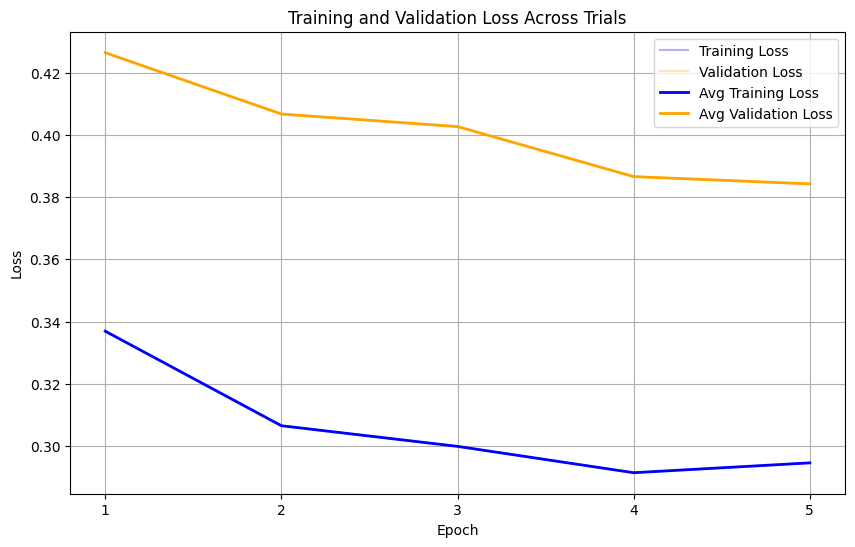

In [ ]:
# Load model without the weights
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=False)

# Adapter la tête de classification pour un problème à 2 classes
model.heads = torch.nn.Linear(model.hidden_dim, 2)
#model.heads.head = nn.Linear(768, 2)

# Load the pretrained model
#model_pre_trained = vit_b_16(weights=True)
#model_pre_trained.heads.head = torch.nn.Linear(model.hidden_dim, 2) (3 Runs and 5 epoh)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define number of trials and epochs
num_epochs = 5
n_trials = 1

# Directory to save the model parameters
save_dir = '/content/drive/MyDrive/ML Project 2 :)/VIT/VIT_b_16_not_pretrained_patience_3'

training_with_patience_b_16(train_loader, val_loader, model, criterion, optimizer, device, num_epochs, n_trials, save_dir, patience=3)

32 minutes per epochs

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_average_roc_b_16(models, val_loader, device, labels):
    """
    Plots the ROC curve for multiple models and their average.

    Args:
        models (list of torch.nn.Module): List of trained models.
        val_loader (DataLoader): DataLoader for the validation set.
        device (torch.device): Device to use (CPU or GPU).
        labels (list of str): Names of the models for legend labeling.
    """
    all_fpr = np.linspace(0, 1, 100)  # Common FPR axis for interpolation
    tpr_list = []  # Store TPR values for each model's interpolated curve
    auc_list = []  # Store AUC values for each model

    plt.figure(figsize=(10, 8))

    for i, model in enumerate(models):
        model.eval()
        true_labels = []
        pred_probs = []

        # Disable gradient computation during evaluation
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                probabilities = outputs[:, 1]  # Use logits for positive class

                # Append true labels and predicted probabilities
                true_labels.extend(labels.cpu().numpy())
                pred_probs.extend(probabilities.cpu().numpy())

        # Calculate ROC curve metrics
        fpr, tpr, _ = roc_curve(true_labels, pred_probs)
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)

        # Interpolate TPR to common FPR axis
        interpolated_tpr = np.interp(all_fpr, fpr, tpr)
        tpr_list.append(interpolated_tpr)

        # Plot individual model's ROC curve in light grey
        plt.plot(fpr, tpr, color='lightgrey', lw=1, label=f"{labels[i]} (AUC = {roc_auc:.2f})")

    # Compute the average TPR
    mean_tpr = np.mean(tpr_list, axis=0)
    mean_auc = auc(all_fpr, mean_tpr)

    # Plot the average ROC curve in blue
    plt.plot(all_fpr, mean_tpr, color='blue', lw=2, label=f"Average (AUC = {mean_auc:.2f})")

    # Add baseline
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Classifier (AUC = 0.5)")

    # Add labels, title, and legend
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Average ROC Curve Across Models")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

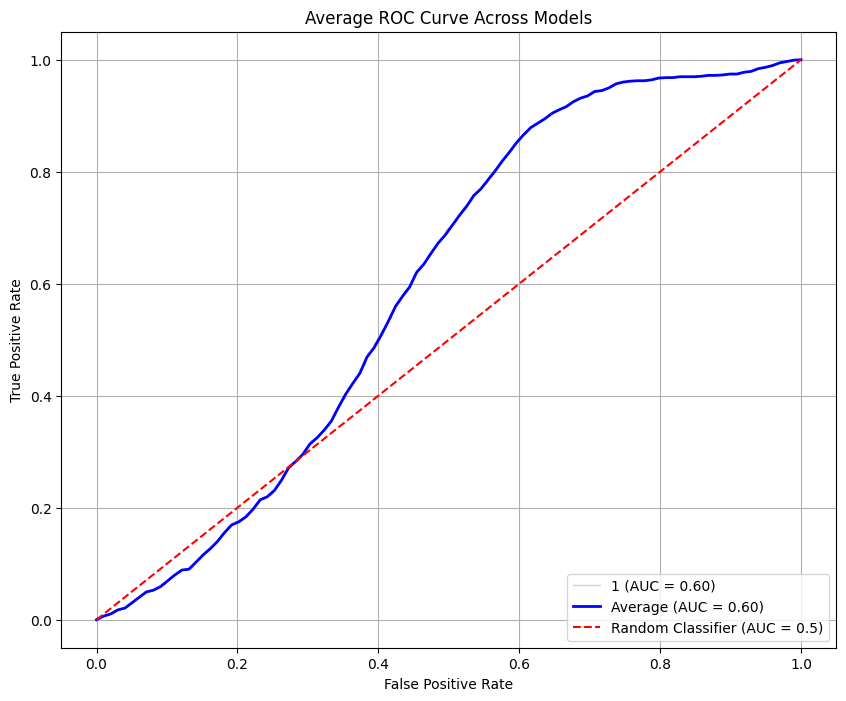

In [ ]:
#model.parameters()
model.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/VIT/VIT_b_16_not_pretrained_patience_3/trial_1_best.pth', weights_only=True))
model = model.to(device)

my_models = [model]
labels = ['VIT-b-16']

plot_average_roc_b_16(my_models, val_loader, device, labels)

## Pre trained base model - with the adapted normalisation

In [ ]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

In [ ]:
# Define the normalization transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Define the full transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 as expected by ViT
    transforms.ToTensor(),         # Convert image to Tensor and rescale to [0, 1]
    normalize                      # Apply normalization
])

train_dataset = datasets.ImageFolder(os.path.join(extract_path, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(extract_path, 'validation'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Trial 1, Epoch 1, Train Loss: 0.3297, Val Loss: 0.3847
Best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/VIT/VIT_b_16_pretrained_patience_3_normalised/trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.3119, Val Loss: 0.3873
Trial 1, Epoch 3, Train Loss: 0.2864, Val Loss: 0.3506
Best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/VIT/VIT_b_16_pretrained_patience_3_normalised/trial_1_best.pth
Trial 1, Epoch 4, Train Loss: 0.2717, Val Loss: 0.3779
Trial 1, Epoch 5, Train Loss: 0.2531, Val Loss: 0.3804
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/VIT/VIT_b_16_pretrained_patience_3_normalised/trial_1_final.pth
Trial 2, Epoch 1, Train Loss: 0.2314, Val Loss: 0.3703
Best model for Trial 2 saved to /content/drive/MyDrive/ML Project 2 :)/VIT/VIT_b_16_pretrained_patience_3_normalised/trial_2_best.pth
Trial 2, Epoch 2, Train Loss: 0.2228, Val Loss: 0.3942
Trial 2, Epoch 3, Train Loss: 0.2154, Val Loss: 0.4027
Trial 2, Epoch 4, Trai

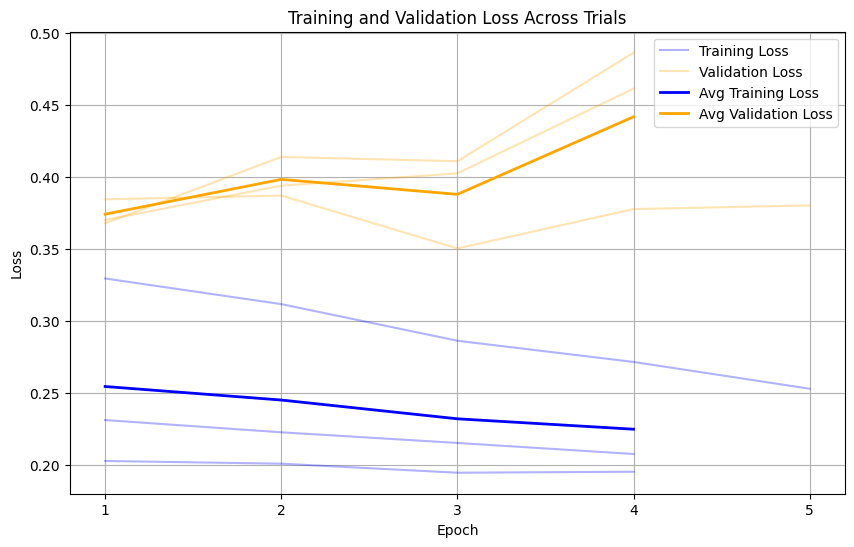

In [ ]:
# Load the pretrained model
model_pre_trained = vit_b_16(weights=True)
model_pre_trained.heads.head = torch.nn.Linear(model_pre_trained.hidden_dim, 2)
#model_pre_trained.heads.head = torch.nn.Linear(model.hidden_dim, 2) (3 Runs and 5 epoh)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pre_trained = model_pre_trained.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pre_trained.parameters(), lr=0.001)

# Define number of trials and epochs
num_epochs = 5
n_trials = 3

# Directory to save the model parameters
save_dir = '/content/drive/MyDrive/ML Project 2 :)/VIT/VIT_b_16_pretrained_patience_3_normalised'

training_with_patience_b_16(train_loader, val_loader, model_pre_trained, criterion, optimizer, device, num_epochs, n_trials, save_dir, patience=3)

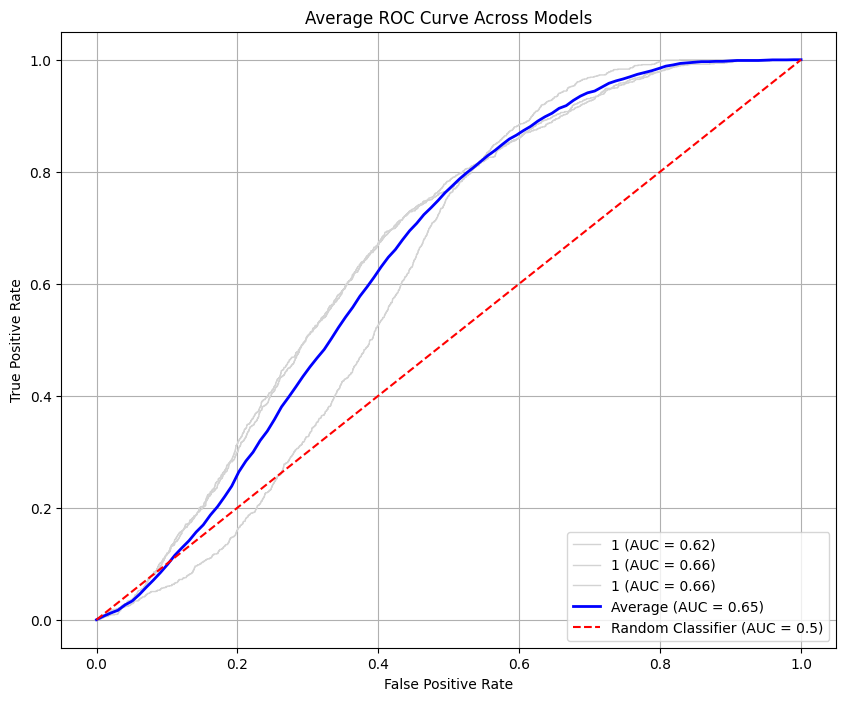

In [ ]:
model1 = vit_b_16(weights=True)
model1.heads.head = torch.nn.Linear(model1.hidden_dim, 2)
model1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/VIT/VIT_b_16_pretrained_patience_3_normalised/trial_1_best.pth', weights_only=True))

model2 = vit_b_16(weights=True)
model2.heads.head = torch.nn.Linear(model2.hidden_dim, 2)
model2.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/VIT/VIT_b_16_pretrained_patience_3_normalised/trial_2_best.pth', weights_only=True))

model3 = vit_b_16(weights=True)
model3.heads.head = torch.nn.Linear(model3.hidden_dim, 2)
model3.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/VIT/VIT_b_16_pretrained_patience_3_normalised/trial_3_best.pth', weights_only=True))

my_models = [model1, model2, model3]
labels = ['VIT-b-16_1', 'VIT-b-16_2', 'VIT-b-16_13']

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for model in my_models:
    model = model.to(device)

plot_average_roc_b_16(my_models, val_loader, device, labels)

Results for the non pretrained vit-b-16

In [ ]:
avg_validation_loss = 0
avg_accuracy = 0
avc_f1 = 0

for model in my_models:
    results = evaluate_model_b_16(model, val_loader, criterion, device)
    avg_validation_loss += results['validation_loss']
    avg_accuracy += results['accuracy']
    avc_f1 += results['f1_score']

avg_validation_loss /= len(my_models)
avg_accuracy /= len(my_models)
avc_f1 /= len(my_models)

print(f"Average Validation Loss: {avg_validation_loss}")
print(f"Average Accuracy: {avg_accuracy}")
print(f"Average F1 Score: {avc_f1}")

Average Validation Loss: 0.3629802756838714
Average Accuracy: 87.47139234242593
Average F1 Score: 0.8264344733508947


Results for the pretrained vit-b-16

In [ ]:
criterion = nn.CrossEntropyLoss()

avg_train_loss = 0
avg_accuracy = 0
avc_f1 = 0

for model in my_models:
    results = evaluate_model_b_16(model, train_loader, criterion, device)
    avg_train_loss += results['validation_loss']
    avg_accuracy += results['accuracy']
    avc_f1 += results['f1_score']

avg_train_loss /= len(my_models)
avg_accuracy /= len(my_models)
avc_f1 /= len(my_models)

print(f"Average Validation Loss: {avg_train_loss}")
print(f"Average Accuracy: {avg_accuracy}")
print(f"Average F1 Score: {avc_f1}")

Average Validation Loss: 0.2418133901663085
Average Accuracy: 90.28413771961756
Average F1 Score: 0.8720270501817762


## Tiny-model

- AutoConfig.from_pretrained : Charge la configuration du modèle (nombre de couches, têtes d'attention, taille des patches, etc.).
Aucun poids pré-entraîné n’est chargé, uniquement l’architecture.

- from_config : Initialise le modèle en utilisant la configuration, avec des poids aléatoires.
Convient pour entraîner un modèle à partir de zéro.

In [ ]:
transform_normalisation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.23642908036708832, 0.22258438169956207, 0.2086913138628006], std=[0.15049093961715698, 0.14338931441307068, 0.13111764192581177])
])

train_dataset = datasets.ImageFolder(os.path.join(extract_path, 'train'), transform=transform_normalisation)
val_dataset = datasets.ImageFolder(os.path.join(extract_path, 'validation'), transform=transform_normalisation)


# Check the shape of an image after transformation
first_image, first_label = train_dataset[0]
print(f"Shape of an image after transformation: {first_image.shape}")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Mean: [0.23642908036708832, 0.22258438169956207, 0.2086913138628006]
Std: [0.15049093961715698, 0.14338931441307068, 0.13111764192581177]
Shape of an image after transformation: torch.Size([3, 224, 224])


In [ ]:
from transformers import AutoImageProcessor, AutoConfig, AutoModelForImageClassification

# Load processor
processor = AutoImageProcessor.from_pretrained("WinKawaks/vit-tiny-patch16-224")

# Load config for a random initialisation
config = AutoConfig.from_pretrained("WinKawaks/vit-tiny-patch16-224")

# Model
model = AutoModelForImageClassification.from_config(config)
model.classifier = nn.Linear(model.config.hidden_size, 2)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Trial 1, Epoch 1, Train Loss: 0.3056, Val Loss: 0.4211
Best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/VIT/VIT_tiny_16_not_pretrained_patience_3/trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.2944, Val Loss: 0.3846
Best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/VIT/VIT_tiny_16_not_pretrained_patience_3/trial_1_best.pth
Trial 1, Epoch 3, Train Loss: 0.2869, Val Loss: 0.4269
Trial 1, Epoch 4, Train Loss: 0.2922, Val Loss: 0.4454
Trial 1, Epoch 5, Train Loss: 0.2828, Val Loss: 0.4059
Early stopping triggered for Trial 1 at Epoch 5
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/VIT/VIT_tiny_16_not_pretrained_patience_3/trial_1_final.pth
Trial 2, Epoch 1, Train Loss: 0.2822, Val Loss: 0.3854
Best model for Trial 2 saved to /content/drive/MyDrive/ML Project 2 :)/VIT/VIT_tiny_16_not_pretrained_patience_3/trial_2_best.pth
Trial 2, Epoch 2, Train Loss: 0.2797, Val Loss: 0.4189
Trial 2, Epoch 3, Train Loss: 0.2817, Val Los

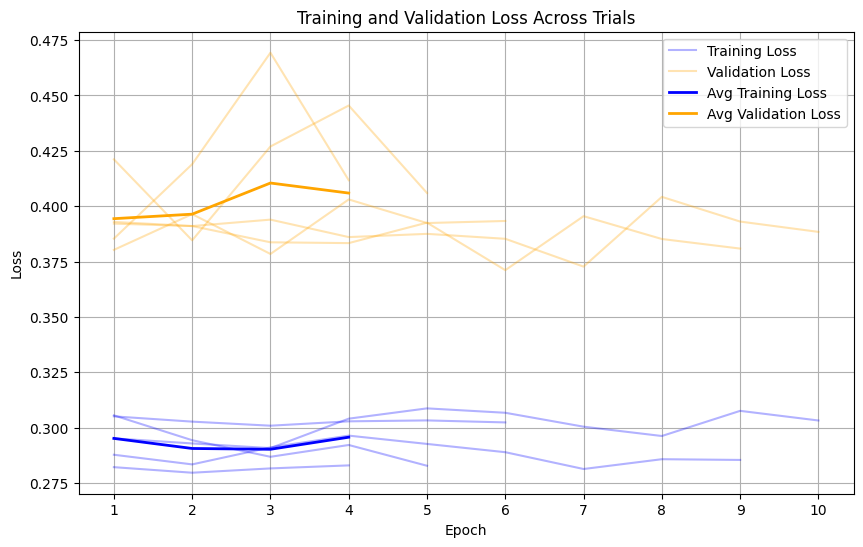

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define number of trials and epochs
num_epochs = 10
n_trials = 5

# Directory to save the model parameters
save_dir = '/content/drive/MyDrive/ML Project 2 :)/VIT/VIT_tiny_16_not_pretrained_patience_3'

training_with_patience(train_loader, val_loader, model, criterion, optimizer, device, num_epochs, n_trials, save_dir, patience=3)

## tiny-model pre-trained

In [ ]:
# Define the normalization transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # weights for ImageNet

# Define the full transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 as expected by ViT
    transforms.ToTensor(),         # Convert image to Tensor and rescale to [0, 1]
    normalize                      # Apply normalization
])

train_dataset = datasets.ImageFolder(os.path.join(extract_path, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(extract_path, 'validation'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("WinKawaks/vit-tiny-patch16-224", use_fast = True)
model = AutoModelForImageClassification.from_pretrained("WinKawaks/vit-tiny-patch16-224")

# Adapt the head for 2 classes
model.classifier = nn.Linear(model.config.hidden_size, 2)

# Vérification
#print(model.classifier)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

5 mins for one epoch

Trial 1, Epoch 1, Train Loss: 0.3421, Val Loss: 0.4205
Best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/VIT_tiny_16_pretrained_patience_3/trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.3080, Val Loss: 0.3988
Best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/VIT_tiny_16_pretrained_patience_3/trial_1_best.pth
Trial 1, Epoch 3, Train Loss: 0.3021, Val Loss: 0.3698
Best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/VIT_tiny_16_pretrained_patience_3/trial_1_best.pth
Trial 1, Epoch 4, Train Loss: 0.3010, Val Loss: 0.3908
Trial 1, Epoch 5, Train Loss: 0.3093, Val Loss: 0.4197
Trial 1, Epoch 6, Train Loss: 0.3053, Val Loss: 0.3753
Early stopping triggered for Trial 1 at Epoch 6
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/VIT_tiny_16_pretrained_patience_3/trial_1_final.pth
Trial 2, Epoch 1, Train Loss: 0.2960, Val Loss: 0.3778
Best model for Trial 2 saved to /content/drive/MyDrive/ML Project 2 :)/VIT_ti

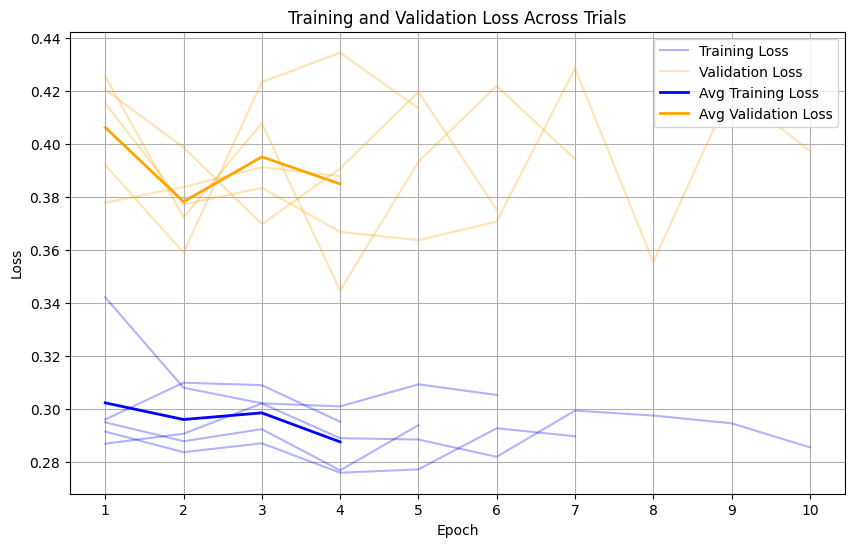

In [ ]:
# Directory to save the model parameters
save_dir = '/content/drive/MyDrive/ML Project 2 :)/VIT_tiny_16_pretrained_patience_3'

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define number of trials and epochs
num_epochs = 10
n_trials = 5

training_with_patience(train_loader, val_loader, model, criterion, optimizer, device, num_epochs, n_trials, save_dir, patience=3)

## ROC curve and AUC

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_average_roc(models, val_loader, device, labels):
    """
    Plots the ROC curve for multiple models and their average.

    Args:
        models (list of torch.nn.Module): List of trained models.
        val_loader (DataLoader): DataLoader for the validation set.
        device (torch.device): Device to use (CPU or GPU).
        labels (list of str): Names of the models for legend labeling.
    """
    all_fpr = np.linspace(0, 1, 100)  # Common FPR axis for interpolation
    tpr_list = []  # Store TPR values for each model's interpolated curve
    auc_list = []  # Store AUC values for each model

    plt.figure(figsize=(10, 8))

    for i, model in enumerate(models):
        model.eval()
        true_labels = []
        pred_probs = []

        # Disable gradient computation during evaluation
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                probabilities = outputs.logits[:, 1]  # Use logits for positive class

                # Append true labels and predicted probabilities
                true_labels.extend(labels.cpu().numpy())
                pred_probs.extend(probabilities.cpu().numpy())

        # Calculate ROC curve metrics
        fpr, tpr, _ = roc_curve(true_labels, pred_probs)
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)

        # Interpolate TPR to common FPR axis
        interpolated_tpr = np.interp(all_fpr, fpr, tpr)
        tpr_list.append(interpolated_tpr)

        # Plot individual model's ROC curve in light grey
        plt.plot(fpr, tpr, color='lightgrey', lw=1, label=f"{labels[i]} (AUC = {roc_auc:.2f})")

    # Compute the average TPR
    mean_tpr = np.mean(tpr_list, axis=0)
    mean_auc = auc(all_fpr, mean_tpr)

    # Plot the average ROC curve in blue
    plt.plot(all_fpr, mean_tpr, color='blue', lw=2, label=f"Average (AUC = {mean_auc:.2f})")

    # Add baseline
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Classifier (AUC = 0.5)")

    # Add labels, title, and legend
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Average ROC Curve Across Models")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

### Not pretrained

In [ ]:
transform_normalisation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.23642908036708832, 0.22258438169956207, 0.2086913138628006], std=[0.15049093961715698, 0.14338931441307068, 0.13111764192581177])
])

train_dataset = datasets.ImageFolder(os.path.join(extract_path, 'train'), transform=transform_normalisation)
val_dataset = datasets.ImageFolder(os.path.join(extract_path, 'validation'), transform=transform_normalisation)


# Check the shape of an image after transformation
first_image, first_label = train_dataset[0]
print(f"Shape of an image after transformation: {first_image.shape}")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Mean: [0.23642908036708832, 0.22258438169956207, 0.2086913138628006]
Std: [0.15049093961715698, 0.14338931441307068, 0.13111764192581177]
Shape of an image after transformation: torch.Size([3, 224, 224])


In [ ]:
from transformers import AutoImageProcessor, AutoConfig, AutoModelForImageClassification

processor1 = AutoImageProcessor.from_pretrained("WinKawaks/vit-tiny-patch16-224")
config1 = AutoConfig.from_pretrained("WinKawaks/vit-tiny-patch16-224")

model1 = AutoModelForImageClassification.from_config(config1)
model1.classifier = nn.Linear(model1.config.hidden_size, 2)
model1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/VIT/VIT_tiny_16_not_pretrained_patience_3/trial_1_best.pth', weights_only=True))

model2 = AutoModelForImageClassification.from_config(config1)
model2.classifier = nn.Linear(model2.config.hidden_size, 2)
model2.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/VIT/VIT_tiny_16_not_pretrained_patience_3/trial_2_best.pth', weights_only=True))

model3 = AutoModelForImageClassification.from_config(config1)
model3.classifier = nn.Linear(model3.config.hidden_size, 2)
model3.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/VIT/VIT_tiny_16_not_pretrained_patience_3/trial_3_best.pth', weights_only=True))

model4 = AutoModelForImageClassification.from_config(config1)
model4.classifier = nn.Linear(model4.config.hidden_size, 2)
model4.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/VIT/VIT_tiny_16_not_pretrained_patience_3/trial_4_best.pth', weights_only=True))

model5 = AutoModelForImageClassification.from_config(config1)
model5.classifier = nn.Linear(model5.config.hidden_size, 2)
model5.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/VIT/VIT_tiny_16_not_pretrained_patience_3/trial_5_best.pth', weights_only=True))

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


<All keys matched successfully>

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

my_models = [model1, model2, model3, model4, model5]
for model in my_models:
    model = model.to(device)

labels = ["model1", "model2", "model3", "model4", "model5"]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


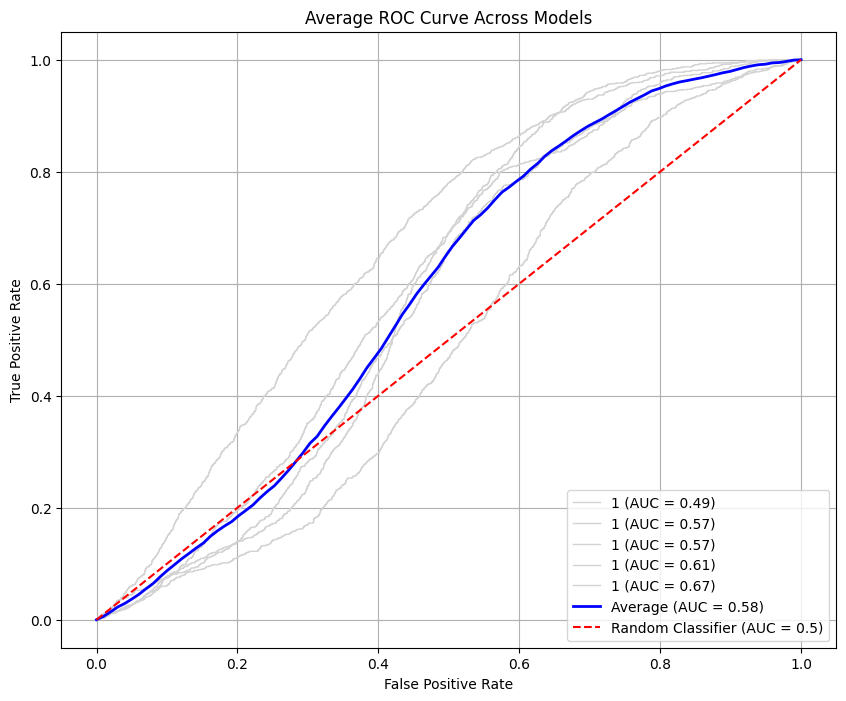

In [ ]:
plot_average_roc(my_models, val_loader, device, labels)

In [ ]:
avg_validation_loss = 0
avg_accuracy = 0
avc_f1 = 0

criterion = nn.CrossEntropyLoss()

for model in my_models:
    results = evaluate_model(model, val_loader, criterion, device)
    avg_validation_loss += results['validation_loss']
    avg_accuracy += results['accuracy']
    avc_f1 += results['f1_score']

avg_validation_loss /= len(my_models)
avg_accuracy /= len(my_models)
avc_f1 /= len(my_models)

print(f"Average Validation Loss: {avg_validation_loss}")
print(f"Average Accuracy: {avg_accuracy}")
print(f"Average F1 Score: {avc_f1}")

Average Validation Loss: 0.37844266399122134
Average Accuracy: 87.94952681388013
Average F1 Score: 0.827732019132454


In [ ]:
avg_train_loss = 0
avg_accuracy = 0
avc_f1 = 0

criterion = nn.CrossEntropyLoss()

for model in my_models:
    results = evaluate_model(model, train_loader, criterion, device)
    avg_train_loss += results['validation_loss']
    avg_accuracy += results['accuracy']
    avc_f1 += results['f1_score']

avg_train_loss /= len(my_models)
avg_accuracy /= len(my_models)
avc_f1 /= len(my_models)

print(f"Average Validation Loss: {avg_train_loss}")
print(f"Average Accuracy: {avg_accuracy}")
print(f"Average F1 Score: {avc_f1}")

Average Validation Loss: 0.29124132632243666
Average Accuracy: 88.80846090471903
Average F1 Score: 0.8441985343633448


### Pretrained model

In [ ]:
from transformers import AutoImageProcessor, AutoConfig, AutoModelForImageClassification

processor1 = AutoImageProcessor.from_pretrained("WinKawaks/vit-tiny-patch16-224")
model1 = AutoModelForImageClassification.from_pretrained("WinKawaks/vit-tiny-patch16-224")
model1.classifier = nn.Linear(model1.config.hidden_size, 2)
model1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/VIT_tiny_16_pretrained_patience_3/trial_1_final.pth', weights_only=True))


processor2 = AutoImageProcessor.from_pretrained("WinKawaks/vit-tiny-patch16-224")
model2 = AutoModelForImageClassification.from_pretrained("WinKawaks/vit-tiny-patch16-224")
model2.classifier = nn.Linear(model2.config.hidden_size, 2)
model2.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/VIT_tiny_16_pretrained_patience_3/trial_2_best.pth', weights_only=True))

processor3 = AutoImageProcessor.from_pretrained("WinKawaks/vit-tiny-patch16-224")
model3 = AutoModelForImageClassification.from_pretrained("WinKawaks/vit-tiny-patch16-224")
model3.classifier = nn.Linear(model3.config.hidden_size, 2)
model3.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/VIT_tiny_16_pretrained_patience_3/trial_3_best.pth', weights_only=True))

processor4 = AutoImageProcessor.from_pretrained("WinKawaks/vit-tiny-patch16-224")
model4 = AutoModelForImageClassification.from_pretrained("WinKawaks/vit-tiny-patch16-224")
model4.classifier = nn.Linear(model4.config.hidden_size, 2)
model4.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/VIT_tiny_16_pretrained_patience_3/trial_4_best.pth', weights_only=True))

processor5 = AutoImageProcessor.from_pretrained("WinKawaks/vit-tiny-patch16-224")
model5 = AutoModelForImageClassification.from_pretrained("WinKawaks/vit-tiny-patch16-224")
model5.classifier = nn.Linear(model5.config.hidden_size, 2)
model5.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/VIT_tiny_16_pretrained_patience_3/trial_5_best.pth', weights_only=True))



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


<All keys matched successfully>

In [ ]:
# Define the normalization transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # weights for ImageNet

# Define the full transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 as expected by ViT
    transforms.ToTensor(),         # Convert image to Tensor and rescale to [0, 1]
    normalize                      # Apply normalization
])

train_dataset = datasets.ImageFolder(os.path.join(extract_path, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(extract_path, 'validation'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

my_models = [model1, model2, model3, model4, model5]
for model in my_models:
    model = model.to(device)

labels = ["model1", "model2", "model3", "model4", "model5"]

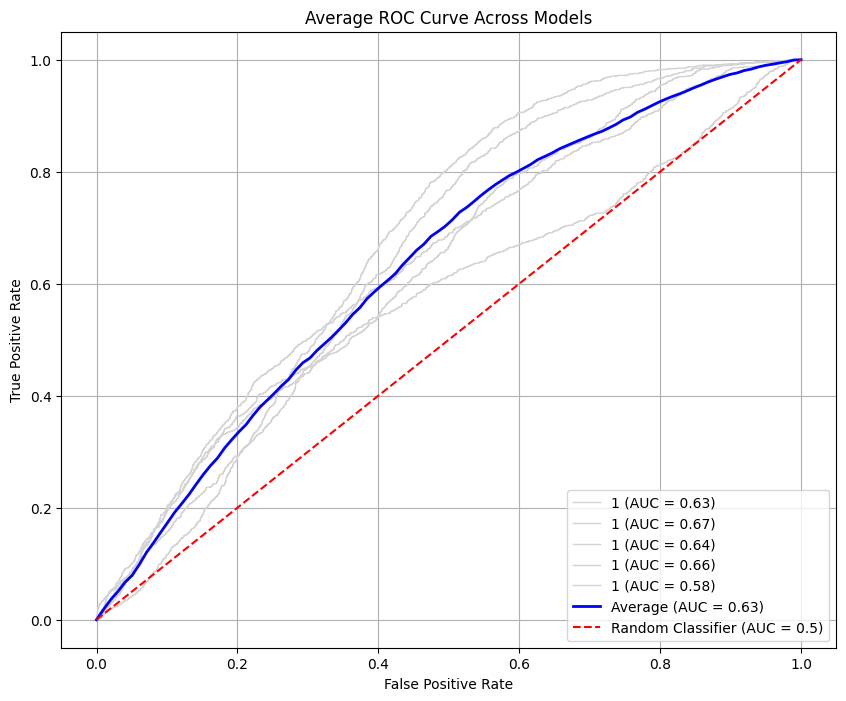

In [ ]:
plot_average_roc(my_models, val_loader, device, labels)

In [ ]:
avg_validation_loss = 0
avg_accuracy = 0
avc_f1 = 0

criterion = nn.CrossEntropyLoss()

for model in my_models:
    results = evaluate_model(model, val_loader, criterion, device)
    avg_validation_loss += results['validation_loss']
    avg_accuracy += results['accuracy']
    avc_f1 += results['f1_score']

avg_validation_loss /= len(my_models)
avg_accuracy /= len(my_models)
avc_f1 /= len(my_models)

print(f"Average Validation Loss: {avg_validation_loss}")
print(f"Average Accuracy: {avg_accuracy}")
print(f"Average F1 Score: {avc_f1}")

Average Validation Loss: 0.3624747357560592
Average Accuracy: 87.58582297272223
Average F1 Score: 0.8274157090234068


In [ ]:
avg_train_loss = 0
avg_accuracy = 0
avc_f1 = 0

criterion = nn.CrossEntropyLoss()

for model in my_models:
    results = evaluate_model(model, train_loader, criterion, device)
    avg_train_loss += results['validation_loss']
    avg_accuracy += results['accuracy']
    avc_f1 += results['f1_score']

avg_train_loss /= len(my_models)
avg_accuracy /= len(my_models)
avc_f1 /= len(my_models)

print(f"Average Validation Loss: {avg_train_loss}")
print(f"Average Accuracy: {avg_accuracy}")
print(f"Average F1 Score: {avc_f1}")

Average Validation Loss: 0.3102276122062832
Average Accuracy: 88.80884409786754
Average F1 Score: 0.8428089408534761
